In [1]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score,recall_score, f1_score
# Seteo para que no se muestre notación científica
np.set_printoptions(suppress=True)
# Saco los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Levanto el dataset
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Separamos en Train y Test

In [3]:
# Separamos en train y test
from sklearn.model_selection import train_test_split

# Variables a procesar
features = ['GrLivArea','GarageArea','GarageCars','OverallQual','SalePrice']
df_limpia = df.dropna(subset= features)
df_train,df_test = train_test_split(df_limpia,
                                    test_size = 0.2, #Porcentaje de muestra test 
                                    random_state = 43) #Semilla
df_train = df_train.reset_index()
df_test = df_test.reset_index()

# Normalizamos los datos

In [4]:
# Normalizamos los datos
from sklearn.preprocessing import StandardScaler

X_train = df_train[features].values
X_test = df_test[features].values

# Defino escalador
sc = StandardScaler()
# Genero parámetros con train
X_train = sc.fit_transform(X_train)
# Le aplico el escalador a test
X_test = sc.transform(X_test)

# Genero df
df_train_scaled = pd.DataFrame(data = X_train)
prefijo = "Scaled_"
df_train_scaled.columns = features
df_train_scaled.add_prefix(prefijo)
df_train_scaled = df_train_scaled.add_prefix(prefijo)
df_test_scaled = pd.DataFrame(data = X_test)
prefijo = "Scaled_"
df_test_scaled.columns = features
df_test_scaled = df_test_scaled.add_prefix(prefijo)

df_train_scaled.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_SalePrice
0,0.503795,1.490732,1.673632,-1.553085,-1.176856
1,1.700533,1.927779,1.673632,1.390531,2.113976
2,-1.295185,-0.521604,0.323630,-1.553085,-0.640993
3,-0.760719,0.054721,0.323630,-0.817181,-0.521211
4,-0.716180,1.572379,-1.026371,-0.817181,-0.470777


# Identificación de Outliers
Para identificarlos vamos a utilizar el algoritmo IsolationForest

In [5]:
df_train_scaled_SinNa = df_train_scaled.dropna()
df_test_scaled_SinNa = df_test_scaled.dropna()


# Genero las matrices sin NAs para correr el algoritmo
X_train = df_train_scaled_SinNa.values
X_test = df_test_scaled_SinNa.values

# Identificar outliers en el dataset de train
iso = IsolationForest(contamination = 0.01) # contamination = proporcion de outliers esperada
yhat = iso.fit_predict(X_train)

# Marco Outlier en train
df_train_scaled_SinNa['EsOutlier'] = yhat == (-1)

# En test: 
yhat_test = iso.predict(X_test)
df_test_scaled_SinNa['EsOutlier'] = yhat_test == (-1)

df_train_scaled_SinNa.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_SalePrice,EsOutlier
0,0.503795,1.490732,1.673632,-1.553085,-1.176856,False
1,1.700533,1.927779,1.673632,1.390531,2.113976,False
2,-1.295185,-0.521604,0.323630,-1.553085,-0.640993,False
3,-0.760719,0.054721,0.323630,-0.817181,-0.521211,False
4,-0.716180,1.572379,-1.026371,-0.817181,-0.470777,False


In [6]:
# Cuántos outliers marcó? 
df_train_scaled_SinNa['EsOutlier'].value_counts()

False    1156
True       12
Name: EsOutlier, dtype: int64

In [7]:
# Identifiquemoslos visualmente con PCA

# Genero PCA sin target
X_train = df_train_scaled_SinNa.drop(['Scaled_SalePrice','EsOutlier'], axis=1).values
X_test = df_test_scaled_SinNa.drop(['Scaled_SalePrice','EsOutlier'], axis=1).values

# Inicio el objeto PCA
pca = PCA()
# Genero componentes con TRAIN
PCA_train = pca.fit_transform(X_train)
# Aplico a test
PCA_test = pca.transform(X_test)

# Almaceno en dataframe y presento
# Train
PCA_train = pd.DataFrame(data = PCA_train)
prefijo = "PC_"
PCA_train = PCA_train.add_prefix(prefijo)
# Test
PCA_test = pd.DataFrame(data = PCA_test)
prefijo = "PC_"
PCA_test = PCA_test.add_prefix(prefijo)

# Me llevo los primeros dos componentes a los dataframes escalados
df_train_scaled_SinNa['PC_0'] = PCA_train['PC_0']
df_test_scaled_SinNa['PC_0'] = PCA_test['PC_0']

df_train_scaled_SinNa.head()


,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_SalePrice,EsOutlier,PC_0
0,0.503795,1.490732,1.673632,-1.553085,-1.176856,False,1.140724
1,1.700533,1.927779,1.673632,1.390531,2.113976,False,3.343711
2,-1.295185,-0.521604,0.323630,-1.553085,-0.640993,False,-1.432666
3,-0.760719,0.054721,0.323630,-0.817181,-0.521211,False,-0.531674
4,-0.716180,1.572379,-1.026371,-0.817181,-0.470777,False,-0.429527


Text(0.5, 1.0, 'Identificación Outliers')

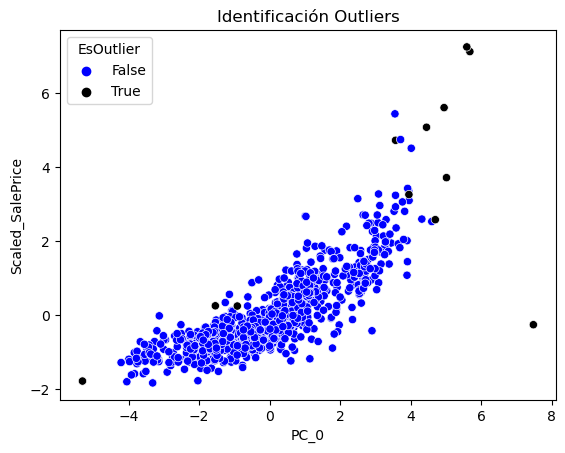

In [8]:
# Visualizo
plt.figure()
sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'PC_0',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',               
                palette={0: 'blue', 1: 'black'})
plt.title('Identificación Outliers')

## ¿Qué nos identificó como outlier?
Veamos la relación entre variables a ver en dónde fueron marcados los outliers. 

Text(0.5, 0.98, 'Relación entre SalePrice y resto de las variables')

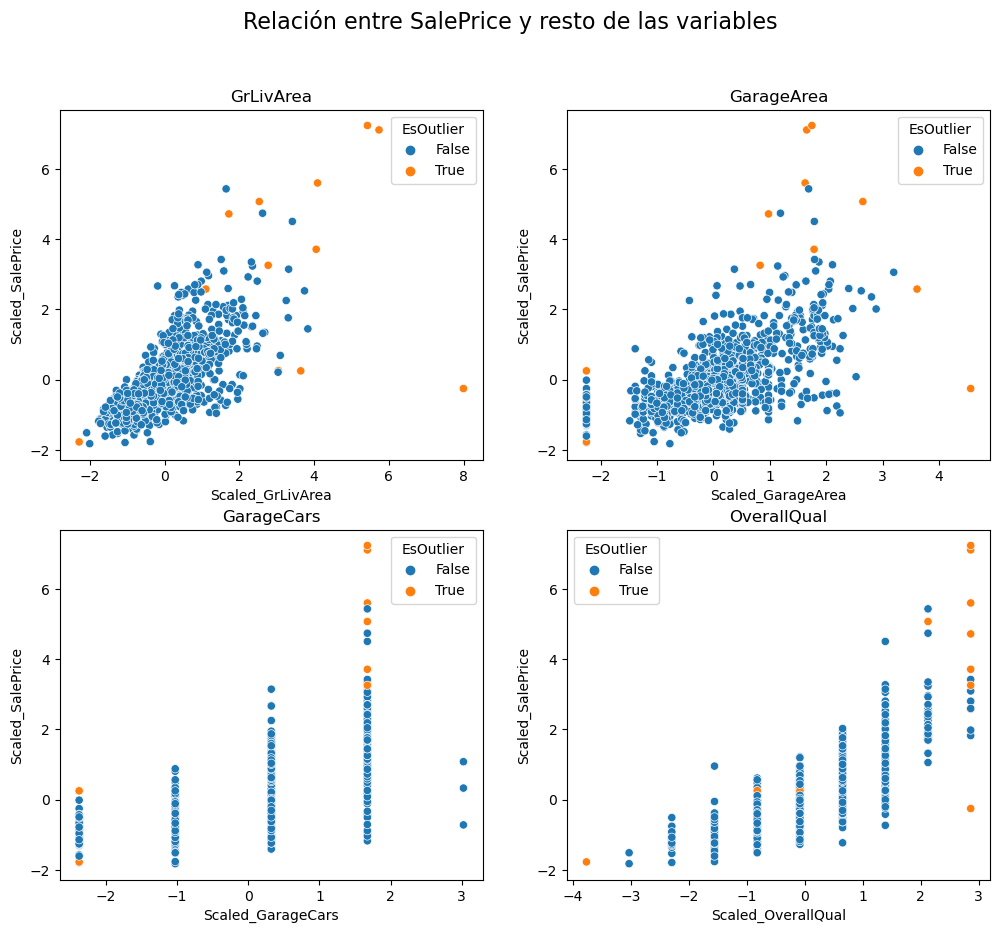

In [9]:

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GrLivArea',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[0, 0])
axs[0, 0].set_title('GrLivArea')

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GarageArea',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[0, 1])
axs[0, 1].set_title('GarageArea')

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GarageCars',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[1, 0])
axs[1, 0].set_title('GarageCars')

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_OverallQual',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[1, 1])
axs[1, 1].set_title('OverallQual')


plt.suptitle('Relación entre SalePrice y resto de las variables', fontsize=16)

# ¿Cómo sigo? 
Vamos a reemplazar por nulos los valores de una de las variables, y vamos a utilizar un algoritmo de  reemplazo de nulos para rellenar esos outliers

### GrLivArea	

In [10]:
# Preprocesamiento 
df_train_scaled_SinNa['Scaled_GrLivArea_NA'] = df_train_scaled_SinNa['Scaled_GrLivArea'] 
df_test_scaled_SinNa['Scaled_GrLivArea_NA'] = df_test_scaled_SinNa['Scaled_GrLivArea'] 
df_train_scaled_SinNa.loc[df_train_scaled_SinNa['EsOutlier'] == True, 'Scaled_GrLivArea_NA'] = None 
df_test_scaled_SinNa.loc[df_test_scaled_SinNa['EsOutlier'] == True, 'Scaled_GrLivArea_NA'] = None 

In [11]:
# Abro librería
from fancyimpute import IterativeImputer

# Genero el imputador
imputador = IterativeImputer(max_iter = 20,
                             random_state = 123)

features_imput_outliers = ['Scaled_GarageArea','Scaled_GarageCars','Scaled_OverallQual','Scaled_GrLivArea_NA']

# Lo entreno
imputador.fit(df_train_scaled_SinNa[features_imput_outliers])

# Lo aplico
df_train_imputada = pd.DataFrame(imputador.transform(df_train_scaled_SinNa[features_imput_outliers]))
df_test_imputada = pd.DataFrame(imputador.transform(df_test_scaled_SinNa[features_imput_outliers]))
df_train_imputada.columns = features_imput_outliers
df_test_imputada.columns = features_imput_outliers

# Asigno nombres de columnas
df_train_scaled_SinNa['Scaled_GrLivArea_Inputada'] = df_train_imputada['Scaled_GrLivArea_NA']
df_test_scaled_SinNa['Scaled_GrLivArea_Inputada'] = df_test_imputada['Scaled_GrLivArea_NA']

df_train_scaled_SinNa.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_SalePrice,EsOutlier,PC_0,Scaled_GrLivArea_NA,Scaled_GrLivArea_Inputada
0,0.503795,1.490732,1.673632,-1.553085,-1.176856,False,1.140724,0.503795,0.503795
1,1.700533,1.927779,1.673632,1.390531,2.113976,False,3.343711,1.700533,1.700533
2,-1.295185,-0.521604,0.323630,-1.553085,-0.640993,False,-1.432666,-1.295185,-1.295185
3,-0.760719,0.054721,0.323630,-0.817181,-0.521211,False,-0.531674,-0.760719,-0.760719
4,-0.716180,1.572379,-1.026371,-0.817181,-0.470777,False,-0.429527,-0.716180,-0.716180


Text(0.5, 1.0, 'Imputando')

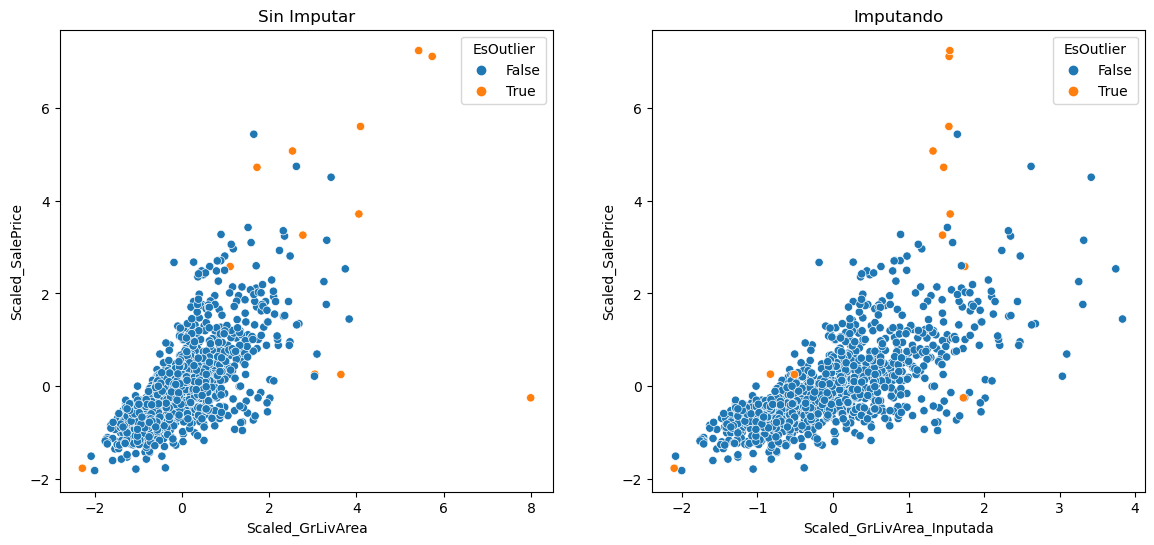

In [12]:
# Y cómo quedó?
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GrLivArea',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[0])

axs[0].set_title('Sin Imputar')

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GrLivArea_Inputada',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[1])

axs[1].set_title('Imputando')

### GarageArea

In [13]:
# Preprocesamiento 
# Preprocesamiento 
df_train_scaled_SinNa['Scaled_GarageArea_NA'] = df_train_scaled_SinNa['Scaled_GarageArea'] 
df_test_scaled_SinNa['Scaled_GarageArea_NA'] = df_test_scaled_SinNa['Scaled_GarageArea'] 
df_train_scaled_SinNa.loc[df_train_scaled_SinNa['EsOutlier'] == True, 'Scaled_GarageArea_NA'] = None 
df_test_scaled_SinNa.loc[df_test_scaled_SinNa['EsOutlier'] == True, 'Scaled_GarageArea_NA'] = None 

In [14]:
# Genero el imputador
imputador = IterativeImputer(max_iter = 20,
                             random_state = 123)

features_imput_outliers = ['Scaled_GarageArea_NA', 'Scaled_GarageCars','Scaled_OverallQual','Scaled_GrLivArea_Inputada']

# Lo entreno
imputador.fit(df_train_scaled_SinNa[features_imput_outliers])

# Lo aplico
df_train_imputada = pd.DataFrame(imputador.transform(df_train_scaled_SinNa[features_imput_outliers]))
df_test_imputada = pd.DataFrame(imputador.transform(df_test_scaled_SinNa[features_imput_outliers]))
df_train_imputada.columns = features_imput_outliers
df_test_imputada.columns = features_imput_outliers

# Asigno nombres de columnas
df_train_scaled_SinNa['Scaled_GarageArea_Inputada'] = df_train_imputada['Scaled_GarageArea_NA']
df_test_scaled_SinNa['Scaled_GarageArea_Inputada'] = df_test_imputada['Scaled_GarageArea_NA']

df_train_scaled_SinNa.head()

,Scaled_GrLivArea,Scaled_GarageArea,Scaled_GarageCars,Scaled_OverallQual,Scaled_SalePrice,EsOutlier,PC_0,Scaled_GrLivArea_NA,Scaled_GrLivArea_Inputada,Scaled_GarageArea_NA,Scaled_GarageArea_Inputada
0,0.503795,1.490732,1.673632,-1.553085,-1.176856,False,1.140724,0.503795,0.503795,1.490732,1.490732
1,1.700533,1.927779,1.673632,1.390531,2.113976,False,3.343711,1.700533,1.700533,1.927779,1.927779
2,-1.295185,-0.521604,0.323630,-1.553085,-0.640993,False,-1.432666,-1.295185,-1.295185,-0.521604,-0.521604
3,-0.760719,0.054721,0.323630,-0.817181,-0.521211,False,-0.531674,-0.760719,-0.760719,0.054721,0.054721
4,-0.716180,1.572379,-1.026371,-0.817181,-0.470777,False,-0.429527,-0.716180,-0.716180,1.572379,1.572379


Text(0.5, 1.0, 'Imputando')

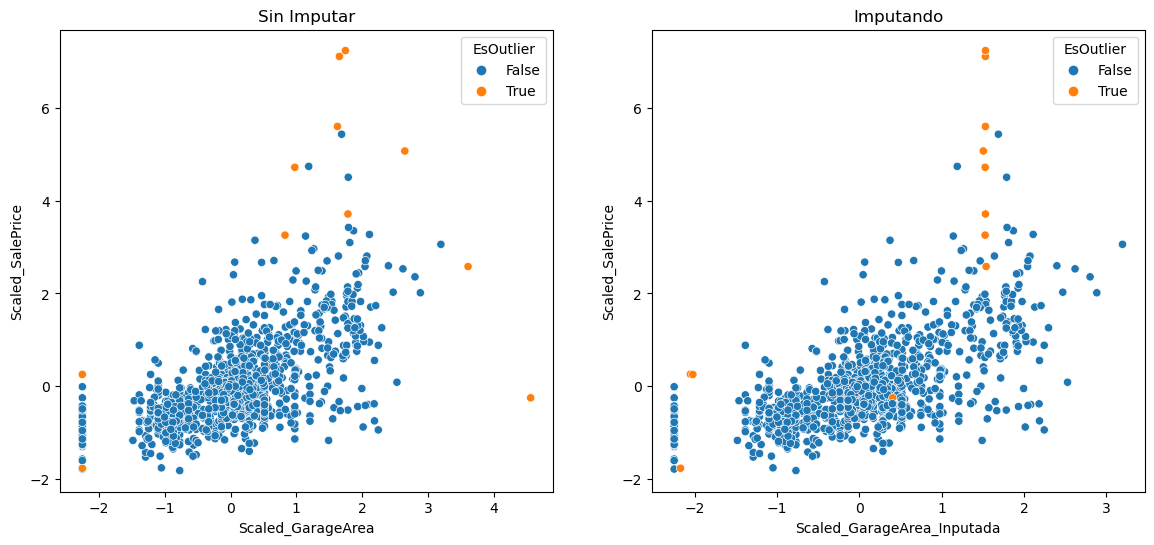

In [15]:
# Y cómo quedó?
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GarageArea',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[0])

axs[0].set_title('Sin Imputar')

sns.scatterplot(data = df_train_scaled_SinNa,
                x = 'Scaled_GarageArea_Inputada',
                y = 'Scaled_SalePrice',
                hue = 'EsOutlier',
                ax = axs[1])

axs[1].set_title('Imputando')

# Replanteando el problema 
En vez de intentar predecir el precio de venta, vamos a predecir la marca de "ES CASA CARA": 

* Target: Si el precio de venta escalado es mayor a 0 entonces suponemos que es casa cara, sino suponemos que es casa barata

In [16]:
df_train_scaled_SinNa.columns

Index(['Scaled_GrLivArea', 'Scaled_GarageArea', 'Scaled_GarageCars',
       'Scaled_OverallQual', 'Scaled_SalePrice', 'EsOutlier', 'PC_0',
       'Scaled_GrLivArea_NA', 'Scaled_GrLivArea_Inputada',
       'Scaled_GarageArea_NA', 'Scaled_GarageArea_Inputada'],
      dtype='object')

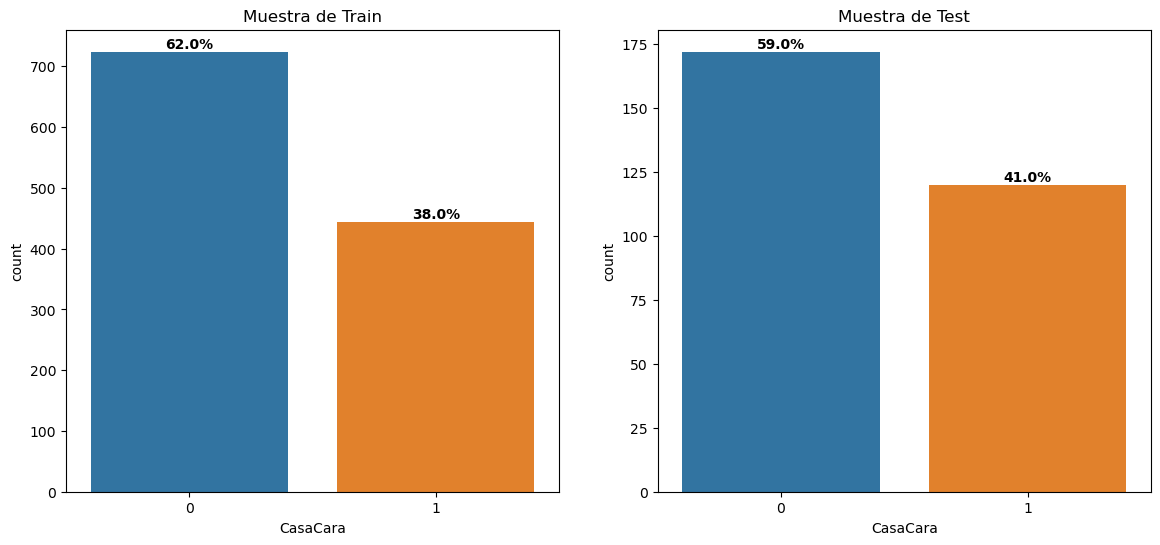

In [17]:
# Construccion del target
df_train_scaled_SinNa['CasaCara'] = np.where(df_train_scaled_SinNa['Scaled_SalePrice'] > 0,1,0)
df_test_scaled_SinNa['CasaCara'] = np.where(df_test_scaled_SinNa['Scaled_SalePrice'] > 0,1,0)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Distribucion en Train
cantidad_1 = len(df_train_scaled_SinNa['CasaCara'])
sns.countplot(data = df_train_scaled_SinNa,
              x = "CasaCara",
              ax = axs[0])
axs[0].set_title('Muestra de Train')
#axs[0] = plt.gca()
for p in axs[0].patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    axs[0].text(x_text, y_text, f'{str(round(int(y_text)/cantidad_1,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
    
# Distribucion en Test
cantidad = len(df_test_scaled_SinNa['CasaCara'])
sns.countplot(data = df_test_scaled_SinNa,
              x = "CasaCara",
              ax = axs[1])
axs[1].set_title('Muestra de Test')
#axs[1] = plt.gca()
for p in axs[1].patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    axs[1].text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
    
plt.show()

# Modelos 
Vamos a trabajar con regresión logística. Vamos a generar dos modelos, con y sin tratamiento de outliers, y evaluaremos las diferencias. 

## Modelo 1: Sin tratamiento de Outliers

In [18]:
# Selecciono features y genero inputs del modelo
features = ['Scaled_GrLivArea', 'Scaled_GarageArea', 'Scaled_GarageCars','Scaled_OverallQual']
X_train = df_train_scaled_SinNa[features].values
y_train = df_train_scaled_SinNa['CasaCara'].values
X_test = df_test_scaled_SinNa[features].values
y_test = df_test_scaled_SinNa['CasaCara'].values

# Genero y entreno
reg_log_1 = LogisticRegression()
reg_log_1.fit(X_train, y_train)

# Predicciones
y_pred_train = reg_log_1.predict(X_train)
y_pred_test = reg_log_1.predict(X_test)
y_pred_prob_train = reg_log_1.predict_proba(X_train)[:,1]
y_pred_prob_test = reg_log_1.predict_proba(X_test)[:,1]

In [19]:
# Metricas
print('TRAIN')
accuracy_rg1_train = round(accuracy_score(y_train, y_pred_train),5)
conf_matrix_rg1_train = confusion_matrix(y_train, y_pred_train)
recall_rg1_train = round(recall_score(y_train, y_pred_train),5)
f1_rg1_train = round(f1_score(y_train, y_pred_train),5)

print(f'Accuracy: {accuracy_rg1_train}')
print(f'Recall: {recall_rg1_train}')
print(f'F1 Score: {f1_rg1_train}')
print(f'Confusion Matrix:\n{conf_matrix_rg1_train}')
print('-----------------------------------------------')
print('-----------------------------------------------')
print('TEST')
accuracy_rg1_test = round(accuracy_score(y_test, y_pred_test),5)
conf_matrix_rg1_test = confusion_matrix(y_test, y_pred_test)
recall_rg1_test = round(recall_score(y_test, y_pred_test),5)
f1_rg1_test = round(f1_score(y_test, y_pred_test),5)

print(f'Accuracy: {accuracy_rg1_test}')
print(f'Confusion Matrix:\n{conf_matrix_rg1_test}')
print(f'Recall: {recall_rg1_test}')
print(f'F1 Score: {f1_rg1_test}')

TRAIN
Accuracy: 0.87928
Recall: 0.82883
F1 Score: 0.83922
Confusion Matrix:
[[659  65]
 [ 76 368]]
-----------------------------------------------
-----------------------------------------------
TEST
Accuracy: 0.90753
Confusion Matrix:
[[164   8]
 [ 19 101]]
Recall: 0.84167
F1 Score: 0.8821


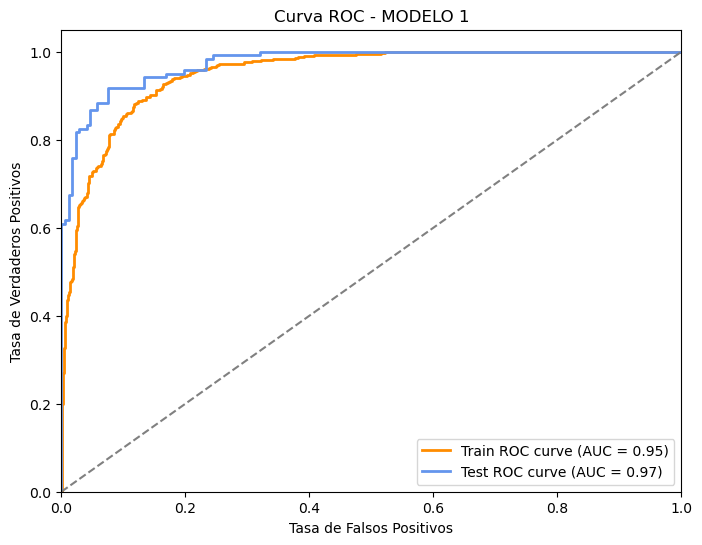

In [20]:
# ROC Y AUC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba
y_train = y_train
y_train_proba = y_pred_prob_train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = y_test
y_test_proba = y_pred_prob_test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
roc_1 = plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 1')
plt.legend(loc='lower right')
plt.show()

## Modelo 2: Con tratamiento de Outliers

In [21]:
# Selecciono features y genero inputs del modelo
features = ['Scaled_GrLivArea_Inputada', 'Scaled_GarageArea_Inputada', 'Scaled_GarageCars','Scaled_OverallQual']
X_train = df_train_scaled_SinNa[features].values
y_train = df_train_scaled_SinNa['CasaCara'].values
X_test = df_test_scaled_SinNa[features].values
y_test = df_test_scaled_SinNa['CasaCara'].values

# Genero y entreno
reg_log_2 = LogisticRegression()
reg_log_2.fit(X_train, y_train)

# Predicciones
y_pred_train = reg_log_2.predict(X_train)
y_pred_test = reg_log_2.predict(X_test)
y_pred_prob_train = reg_log_2.predict_proba(X_train)[:,1]
y_pred_prob_test = reg_log_2.predict_proba(X_test)[:,1]

In [22]:
# Metricas
print('TRAIN')
accuracy_rg2_train = round(accuracy_score(y_train, y_pred_train),5)
conf_matrix_rg2_train = confusion_matrix(y_train, y_pred_train)
recall_rg2_train = round(recall_score(y_train, y_pred_train),5)
f1_rg2_train = round(f1_score(y_train, y_pred_train),5)

print(f'Accuracy: {accuracy_rg2_train}')
print(f'Recall: {recall_rg2_train}')
print(f'F1 Score: {f1_rg2_train}')
print(f'Confusion Matrix:\n{conf_matrix_rg2_train}')
print('-----------------------------------------------')
print('-----------------------------------------------')
print('TEST')
accuracy_rg2_test = round(accuracy_score(y_test, y_pred_test),5)
conf_matrix_rg2_test = confusion_matrix(y_test, y_pred_test)
recall_rg2_test = round(recall_score(y_test, y_pred_test),5)
f1_rg2_test = round(f1_score(y_test, y_pred_test),5)

print(f'Accuracy: {accuracy_rg2_test}')
print(f'Confusion Matrix:\n{conf_matrix_rg2_test}')
print(f'Recall: {recall_rg2_test}')
print(f'F1 Score: {f1_rg2_test}')

TRAIN
Accuracy: 0.88185
Recall: 0.83108
F1 Score: 0.84247
Confusion Matrix:
[[661  63]
 [ 75 369]]
-----------------------------------------------
-----------------------------------------------
TEST
Accuracy: 0.91781
Confusion Matrix:
[[166   6]
 [ 18 102]]
Recall: 0.85
F1 Score: 0.89474


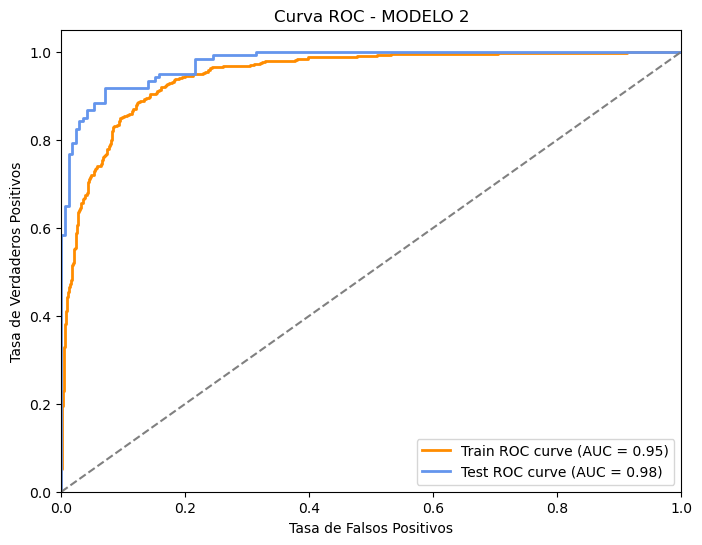

In [23]:
# ROC Y AUC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba
y_train = y_train
y_train_proba = y_pred_prob_train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = y_test
y_test_proba = y_pred_prob_test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
roc_2 = plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 2')
plt.legend(loc='lower right')
plt.show()

# Modelo 1 vs Modelo 2

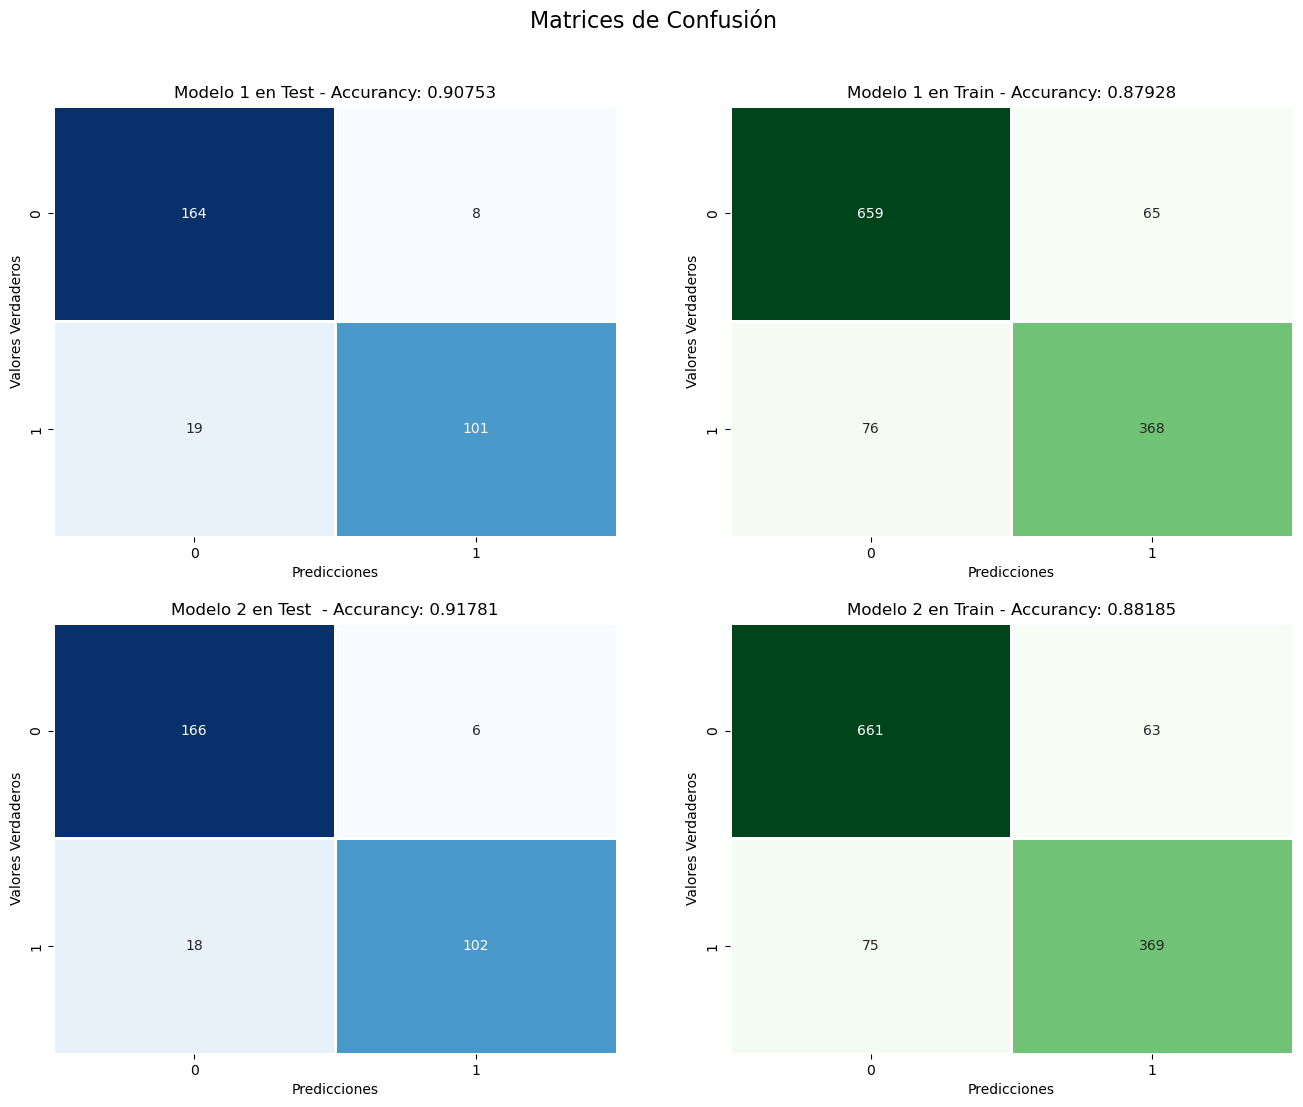

In [24]:
# Matrices de confusión
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(conf_matrix_rg1_test, 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            linewidths = 2,
            ax = axs[0,0],
            cbar=False)
axs[0,0].set_title('Modelo 1 en Test - Accurancy: '+str(accuracy_rg1_test))
axs[0,0].set_xlabel('Predicciones')
axs[0,0].set_ylabel('Valores Verdaderos')

sns.heatmap(conf_matrix_rg1_train, 
            annot=True, 
            fmt="d", 
            cmap="Greens",
            linewidths = 2,
            ax = axs[0,1],
            cbar=False)
axs[0,1].set_title('Modelo 1 en Train - Accurancy: '+ str(accuracy_rg1_train))
axs[0,1].set_xlabel('Predicciones')
axs[0,1].set_ylabel('Valores Verdaderos')



sns.heatmap(conf_matrix_rg2_test, 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            linewidths = 2,
            ax = axs[1,0],
            cbar=False)
axs[1,0].set_title('Modelo 2 en Test  - Accurancy: '+ str(accuracy_rg2_test))
axs[1,0].set_xlabel('Predicciones')
axs[1,0].set_ylabel('Valores Verdaderos')

sns.heatmap(conf_matrix_rg2_train, 
            annot=True, 
            fmt="d", 
            cmap="Greens",
            linewidths = 2,
            ax = axs[1,1],
            cbar=False)
axs[1,1].set_title('Modelo 2 en Train - Accurancy: '+ str(accuracy_rg2_train))
axs[1,1].set_xlabel('Predicciones')
axs[1,1].set_ylabel('Valores Verdaderos')

plt.suptitle('Matrices de Confusión', fontsize=16)
plt.subplots_adjust(top=0.9)  # Ajusta la posición del título general

plt.show()


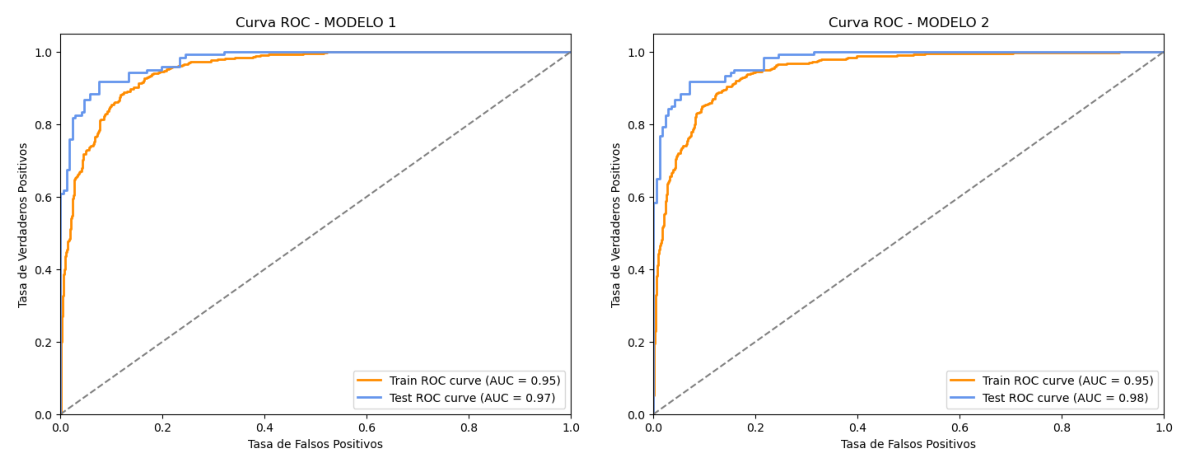

In [25]:
# Curvas de ROC
fig, axes = plt.subplots(1,2, figsize=(12, 8))

ax1 = axes[0]
ax2 = axes[1]

ax1.axis('off')
ax1.imshow(roc_1.canvas.renderer.buffer_rgba())  
ax2.axis('off')
ax2.imshow(roc_2.canvas.renderer.buffer_rgba())

plt.tight_layout()

plt.show()